In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jun 18 18:04:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Specify the current work folder
import os
os.chdir("/content/drive/MyDrive/AttentiveFP/code/")

In [5]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install -c conda-forge rdkit

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:15
🔁 Restarting kernel...

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [4]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

In [5]:
import random
from rdkit.Chem import rdMolDescriptors, MolSurf, rdDepictor
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import rdMolDraw2D, MolToFile, _moltoimg
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

number of all smiles:  2928
number of successfully processed smiles:  2928


<ipython-input-6-02f54730ef72>:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(atom_num_dist, bins=28, kde=False)


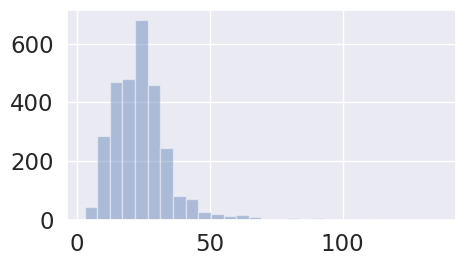

In [6]:
task_name = 'Anti'
tasks = ['Anti']
raw_filename = "../data/Anti_plus_v2.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
#print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [7]:
smiles_tasks_df

,Anti,smiles,cas,cano_smiles
0,0,S=P(N1CC1)(N1CC1)N1CC1,2621,S=P(N1CC1)(N1CC1)N1CC1
1,0,S=C1SCN(Cc2ccccc2)CN1Cc1ccccc1,2620,S=C1SCN(Cc2ccccc2)CN1Cc1ccccc1
2,0,S=c1[nH]cnc2nc[nH]c12,2619,S=c1[nH]cnc2nc[nH]c12
3,0,S=C=NCc1ccccc1,2618,S=C=NCc1ccccc1
4,0,S=C=Nc1ccc(N=C=S)cc1,2617,S=C=Nc1ccc(N=C=S)cc1
...,...,...,...,...
2923,0,Br.Cc1ccc(Sc2ccccc2N2CCNCC2)c(C)c1,5,Br.Cc1ccc(Sc2ccccc2N2CCNCC2)c(C)c1
2924,0,Br.CC(Cc1ccc(O)cc1)NCC(O)c1cc(O)cc(O)c1,4,Br.CC(Cc1ccc(O)cc1)NCC(O)c1cc(O)cc(O)c1
2925,0,[O-][n+]1cccc(CO)c1,3,[O-][n+]1cccc(CO)c1
2926,0,[O-][N+](=O)c1ncc[nH]1,2,O=[N+]([O-])c1ncc[nH]1


In [8]:
random_seed = 88
#random_seed = int(time.time())
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 500
p_dropout = 0.1
fingerprint_dim = 150

radius = 3
T = 2
weight_decay = 2.9 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [9]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<101]
uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>100]

smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,Anti,smiles,cas,cano_smiles
608,0,N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O.O.O.[Na+].[Na+],2071,N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O.O.O.[Na+].[Na+]


In [10]:
weights = []
for i,task in enumerate(tasks):
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])

test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# train_df.to_csv("trainset.csv",index=False)
# test_df.to_csv("testset.csv",index=False)

In [11]:
test_df[test_df[task] == 1][["smiles",task]]

,smiles,Anti
3,CCCCCCCCCCCCCCCCCC[N+](C)(C)C,1
7,O1[n+]2ccccc2S[Zn]11O[n+]2ccccc2S1,1
10,COc1ccc2c(c1OC)C(=O)OC2C1c2c(cc3c(c2OC)OCO3)CC...,1
34,CCN1CCN(c2cc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC1,1
36,Cc1nnc(SCC2=C(C(=O)[O-])N3C(=O)C(NC(=O)Cn4cnnn...,1
39,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(CSc3nc(=O)c(O)nn...,1
44,CCCCCCCCCCCCCC[N+](C)(C)CC,1
83,CC(=O)OCC1=C(C(=O)[O-])N2C(=O)C(NC(=O)Cc3cccs3...,1
105,Cl.O=C(O)c1cn(-c2ccc(F)cc2)c2cc(N3CCNCC3)c(F)c...,1
106,Cl.NC1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(C4CC4)c3c2...,1


In [12]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)


649206
atom_fc.weight torch.Size([150, 39])
atom_fc.bias torch.Size([150])
neighbor_fc.weight torch.Size([150, 49])
neighbor_fc.bias torch.Size([150])
GRUCell.0.weight_ih torch.Size([450, 150])
GRUCell.0.weight_hh torch.Size([450, 150])
GRUCell.0.bias_ih torch.Size([450])
GRUCell.0.bias_hh torch.Size([450])
GRUCell.1.weight_ih torch.Size([450, 150])
GRUCell.1.weight_hh torch.Size([450, 150])
GRUCell.1.bias_ih torch.Size([450])
GRUCell.1.bias_hh torch.Size([450])
GRUCell.2.weight_ih torch.Size([450, 150])
GRUCell.2.weight_hh torch.Size([450, 150])
GRUCell.2.bias_ih torch.Size([450])
GRUCell.2.bias_hh torch.Size([450])
align.0.weight torch.Size([1, 300])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 300])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 300])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([150, 150])
attend.0.bias torch.Size([150])
attend.1.weight torch.Size([150, 150])
attend.1.bias torch.Size([150])
attend.2.weight torch.Size([150, 150])

In [13]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values

        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())

        model.zero_grad()
        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values

        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)
    test_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    test_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     test_prc = auc(recall, precision)
    test_precision = [precision_score(y_val_list[i],
                                     (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_recall = [recall_score(y_val_list[i],
                               (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_loss = np.array(losses_list).mean()

    test_cm1 = [confusion_matrix(y_val_list[i],
                               (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]

    test_cm2 = [confusion_matrix(y_val_list[i],
                               (np.array(y_pred_list[i]) > 0.7).astype(int)) for i in range(len(tasks))]
    test_roc_curve = [roc_curve(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    test_prc_curve = [precision_recall_curve(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    return test_roc, test_prc, test_precision, test_recall, test_loss, test_cm1, test_cm2, test_roc_curve, test_prc_curve

In [14]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8


In [ ]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):
    train_roc, train_prc, train_precision, train_recall, train_loss, test_cm1, test_cm2, test_roc_curve, test_prc_curve = eval(model, train_df)
    valid_roc, valid_prc, valid_precision, valid_recall, valid_loss, valid_cm1, valid_cm2, valid_roc_curve, valid_prc_curve = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()

#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.90:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
        +"train_loss"+":"+str(train_loss)+'\n'\
        +"valid_loss"+":"+str(valid_loss)+'\n'\
#         +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
#         +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >10) and (epoch - best_param["loss_epoch"] >20):
         break

    train(model, train_df, optimizer, loss_function)

In [15]:
# evaluate model
#best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')
best_model = torch.load('saved_models/model_Anti_plus_v2_Sun_Jun_11_14-41-40_2023_153'+'.pt')

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()

test_roc, test_prc, test_precision, test_recall, test_losse, test_cm1, test_cm2, test_roc_curve, test_prc_curve = eval(best_model, test_df)
#test_fpr, test_tpr, test_threshold  = eval(best_model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_prc:"+str(test_prc)
      +"\n"+"cm1:",test_cm1
     )
best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)


best epoch:0
test_roc:[0.9932359307359307]
test_prc:[0.9244047957941958]
cm1: [array([[246,  18],
       [  0,  28]])]


In [ ]:
print("cm2:",test_cm2)

cm2: [array([[259,   5],
       [  3,  25]])]


In [ ]:
train_roc, train_prc, train_precision, train_recall, train_losse, train_cm1, train_cm2, train_roc_curve, train_prc_curve  = eval(best_model, train_df)

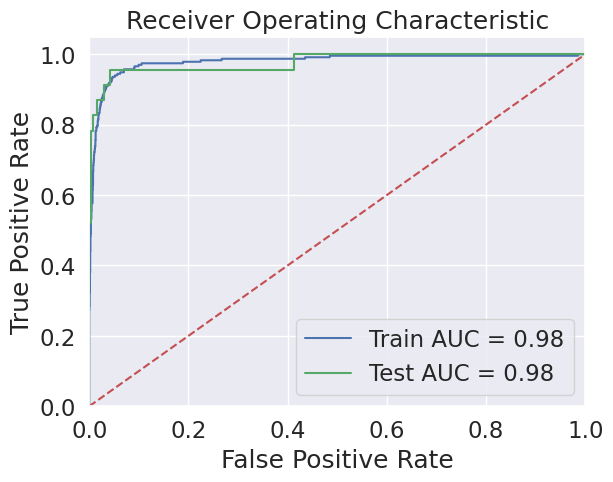

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

test_fpr, test_tpr, test_threshold = test_roc_curve[0]
train_fpr, train_tpr, train_threshold = train_roc_curve[0]

train_roc_auc = auc(train_fpr, train_tpr)
test_roc_auc = auc(test_fpr, test_tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'Train AUC = %0.2f' % train_roc_auc)
plt.plot(test_fpr, test_tpr, 'g', label = 'Test AUC = %0.2f' % test_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("ROC.svg",dpi=1200) #.png,.pdf will also support here
plt.show()

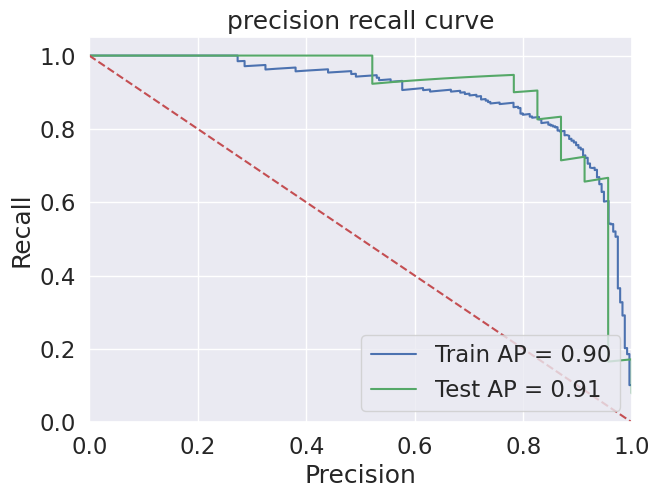

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
fig, ax = plt.subplots(figsize=[7,5])
# calculate the fpr and tpr for all thresholds of the classification
train_precision, train_recall, _ = train_prc_curve[0]
test_precision, test_recall, _ = test_prc_curve[0]

train_ap = auc(train_recall, train_precision)
test_ap = auc(test_recall, test_precision)

plt.title('precision recall curve')
plt.plot(train_recall, train_precision, 'b', label = 'Train AP = %0.2f' % train_ap)
plt.plot(test_recall, test_precision, 'g', label = 'Test AP = %0.2f' % test_ap)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.savefig("PRC.svg",dpi=1200) #.png,.pdf will also support here
plt.show()

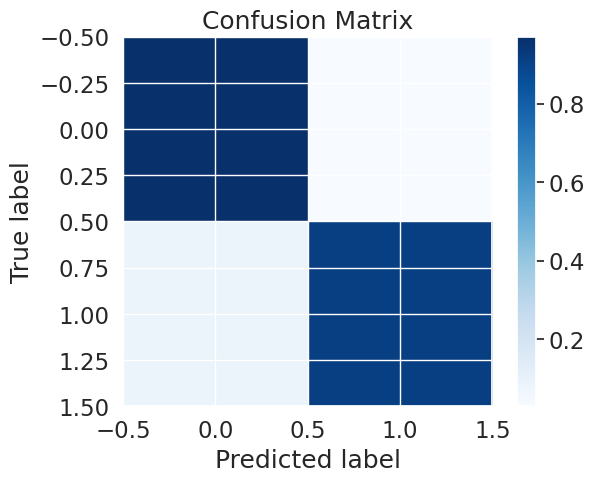

In [ ]:
def plot_confusion_matrix(cm):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    # Normalize the confusion matrix
    plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)    # Display the image in the specified window
    plt.title('Confusion Matrix')    # Title of the image
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("confusion_matrix.svg",dpi=1200) #.png,.pdf will also support here
plot_confusion_matrix(test_cm2[0])

In [16]:
def min_max_norm(dataset):
    if isinstance(dataset, list):
        norm_list = list()
        min_value = min(dataset)
        max_value = max(dataset)

        for value in dataset:
            tmp = (value - min_value) / (max_value - min_value)
            norm_list.append(tmp)
    return norm_list

In [17]:
raw_filename = "../data/QAC_Anti.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
#print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

number of all smiles:  50
number of successfully processed smiles:  50


In [ ]:
canonical_smiles_list

['C=O',
 'N=C(N)N',
 'CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO',
 'CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(O)CC21C',
 'CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(=O)CC21C',
 'CCC1(c2ccccc2)C(=O)NC(=O)NC1=O',
 'COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12',
 'CN1C(=O)C(C)(C2=CCCCC2)C(=O)N=C1O',
 'CC[N+](C)(CC)CCOC(=O)C(O)(c1ccccc1)C1CCCCC1',
 'CCC1(CC)C(=O)NC(=O)N(C)C1=O',
 'CCC1(c2ccccc2)NC(=O)N(C)C1=O',
 'CCOC(=O)C1(c2ccccc2)CCN(C)CC1',
 'C=C1CCC(O)CC1=CC=C1CCCC2(C)C1CCC2C(C)C=CC(C)C(C)C',
 'O=P1(N(CCCl)CCCl)NCCCO1',
 'CCC(O)(COC(N)=O)c1ccccc1',
 'CC(O)C(=O)O',
 'CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C(C(=O)CO)CCC12',
 'CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO',
 'CC12C=CC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO',
 'CC12CCC3c4ccc(O)cc4CCC3C1CC(O)C2O',
 'CC12CCC3c4ccc(O)cc4CCC3C1CCC2O',
 'Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)(Cl)Cl)cc1',
 'O=C(O)c1c(Cl)cccc1Cl',
 'O=C(O)c1c(Cl)ccc(Cl)c1Cl',
 'c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34',
 'CCCCC1C(=O)N(c2ccccc2)N(c2ccccc2)C1=O'

In [ ]:
for smiles in canonical_smiles_list:
    try:
      Chem.MolFromSmiles(smiles).GetAtoms()
    except:
      print(smiles)
    pass

[01:47:59] WARNING: not removing hydrogen atom without neighbors
[01:47:59] WARNING: not removing hydrogen atom without neighbors
[01:47:59] WARNING: not removing hydrogen atom without neighbors
[01:47:59] WARNING: not removing hydrogen atom without neighbors
[01:47:59] WARNING: not removing hydrogen atom without neighbors
[01:47:59] WARNING: not removing hydrogen atom without neighbors
[01:47:59] WARNING: not removing hydrogen atom without neighbors
[01:47:59] WARNING: not removing hydrogen atom without neighbors
[01:47:59] WARNING: not removing hydrogen atom without neighbors
[01:48:00] WARNING: not removing hydrogen atom without neighbors
[01:48:00] WARNING: not removing hydrogen atom without neighbors
[01:48:00] WARNING: not removing hydrogen atom without neighbors
[01:48:00] WARNING: not removing hydrogen atom without neighbors
[01:48:00] WARNING: not removing hydrogen atom without neighbors
[01:48:00] WARNING: not removing hydrogen atom without neighbors
[01:48:00] WARNING: not r

In [18]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<101]
uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>100]

smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,Anti,smiles,cas,cano_smiles


In [19]:
def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

In [20]:
# Feature visualization

model_for_viz = Fingerprint_viz(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model_for_viz.cuda()

model_for_viz.load_state_dict(best_model_wts)
(best_model.align[0].weight == model_for_viz.align[0].weight).all()



tensor(True)

CAS: 1
prediction_Anti_value: 0.9608532
SMILES: CCCCCCCC[N+](C)(C)C


<ipython-input-22-84bd0cc42c48>:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Oranges')
[18:08:20] The new font size 1 is below the current minimum (6).


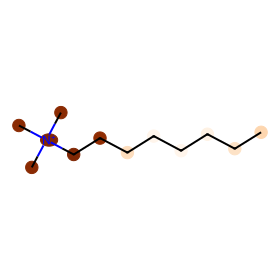

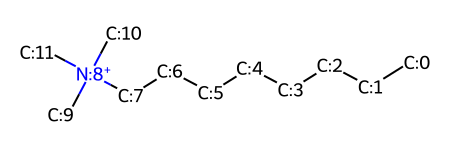

CAS: 2
prediction_Anti_value: 0.997332
SMILES: CCCCCCCCCC[N+](C)(C)C


[18:08:20] The new font size 1 is below the current minimum (6).


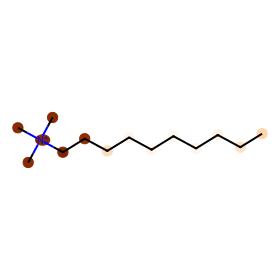

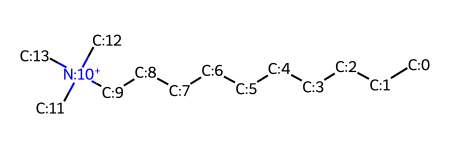

CAS: 3
prediction_Anti_value: 0.999471
SMILES: CCCCCCCCCCCC[N+](C)(C)C


[18:08:20] The new font size 1 is below the current minimum (6).


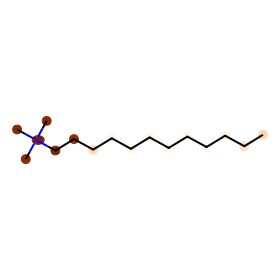

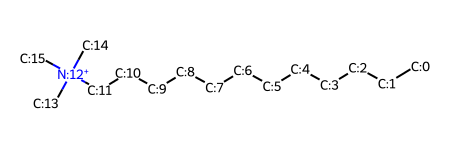

CAS: 4
prediction_Anti_value: 0.9997818
SMILES: CCCCCCCCCCCCCC[N+](C)(C)C


[18:08:20] The new font size 1 is below the current minimum (6).


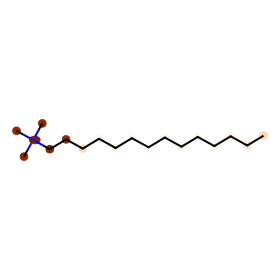

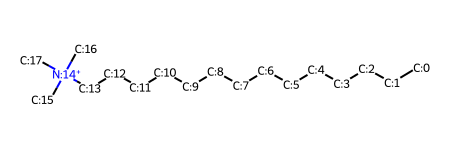

CAS: 5
prediction_Anti_value: 0.9998579
SMILES: CCCCCCCCCCCCCCCC[N+](C)(C)C


[18:08:20] The new font size 1 is below the current minimum (6).


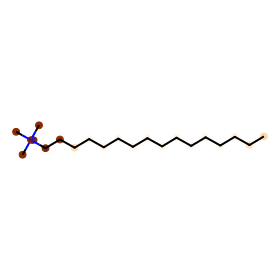

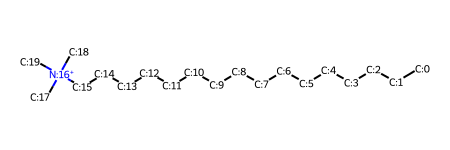

CAS: 6
prediction_Anti_value: 0.9998617
SMILES: CCCCCCCCCCCCCCCCCC[N+](C)(C)C


[18:08:20] The new font size 1 is below the current minimum (6).


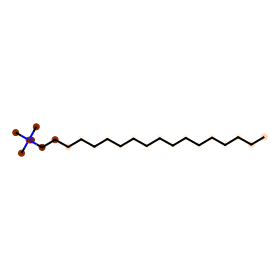

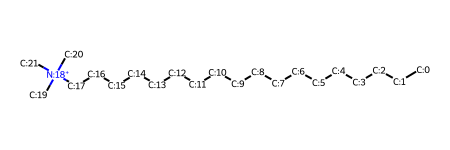

CAS: 7
prediction_Anti_value: 0.99979705
SMILES: CCCCCCCCCCCCCCCCCCCC[N+](C)(C)C


[18:08:20] The new font size 1 is below the current minimum (6).


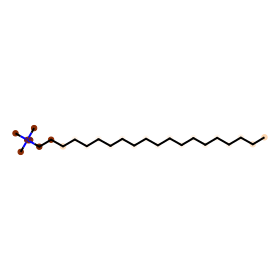

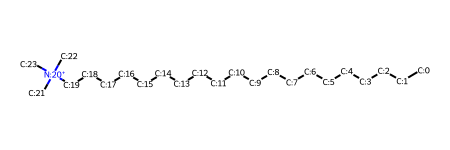

CAS: 8
prediction_Anti_value: 0.9995497
SMILES: CCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C


[18:08:20] The new font size 1 is below the current minimum (6).


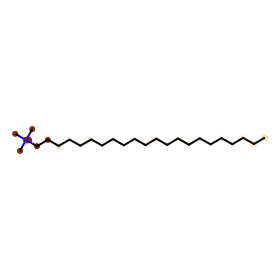

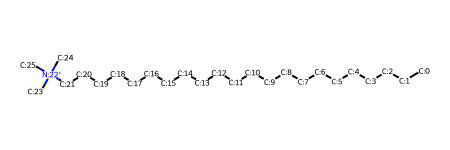

CAS: 9
prediction_Anti_value: 0.9985261
SMILES: CCCCCCCCCCCCCCCCCCCCCCCC[N+](C)(C)C


[18:08:20] The new font size 1 is below the current minimum (6).


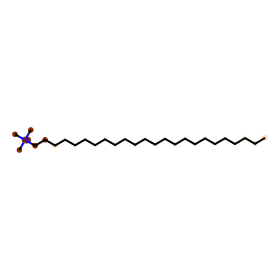

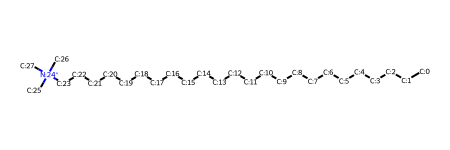

CAS: 10
prediction_Anti_value: 0.9992593
SMILES: CCCCCCCC[N+](C)(C)Cc1ccccc1


[18:08:20] The new font size 1 is below the current minimum (6).


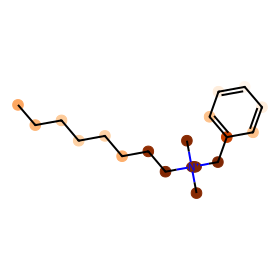

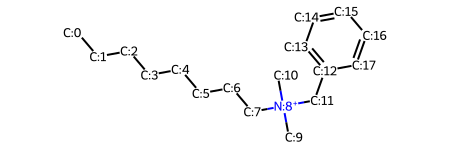

CAS: 11
prediction_Anti_value: 0.99968946
SMILES: CCCCCCCCCC[N+](C)(C)Cc1ccccc1


[18:08:20] The new font size 1 is below the current minimum (6).


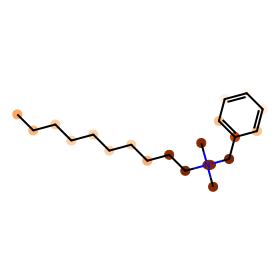

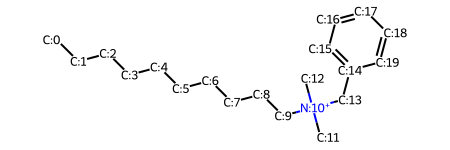

CAS: 12
prediction_Anti_value: 0.99977845
SMILES: CCCCCCCCCCCC[N+](C)(C)Cc1ccccc1


[18:08:20] The new font size 1 is below the current minimum (6).


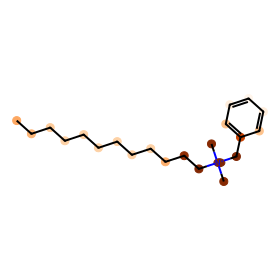

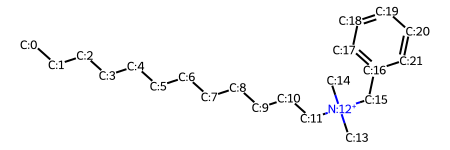

CAS: 13
prediction_Anti_value: 0.99977976
SMILES: CCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1


[18:08:20] The new font size 1 is below the current minimum (6).


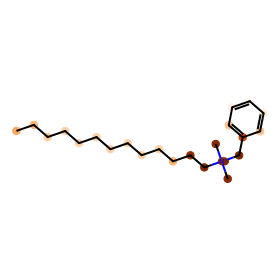

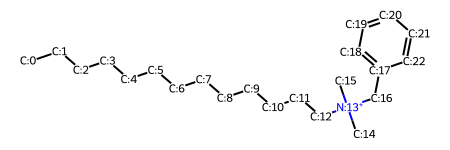

CAS: 14
prediction_Anti_value: 0.99975675
SMILES: CCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1


[18:08:20] The new font size 1 is below the current minimum (6).


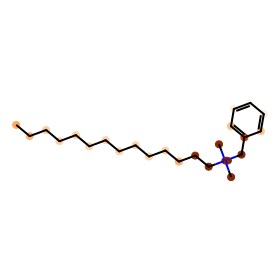

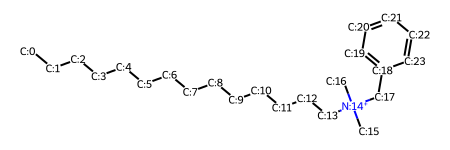

CAS: 15
prediction_Anti_value: 0.99959594
SMILES: CCCCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1


[18:08:20] The new font size 1 is below the current minimum (6).


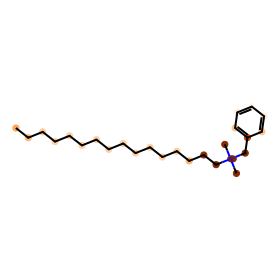

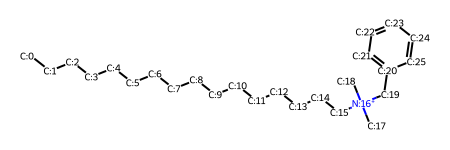

CAS: 16
prediction_Anti_value: 0.99899775
SMILES: CCCCCCCCCCCCCCCCCC[N+](C)(C)Cc1ccccc1


[18:08:20] The new font size 1 is below the current minimum (6).


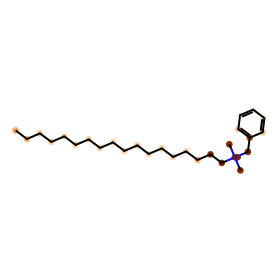

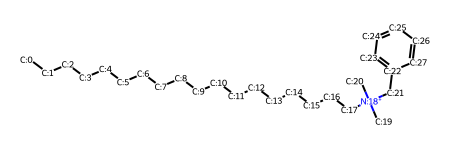

CAS: 17
prediction_Anti_value: 0.99983084
SMILES: CCCCCCCC[N+](C)(C)CCCCCCCC


[18:08:21] The new font size 1 is below the current minimum (6).


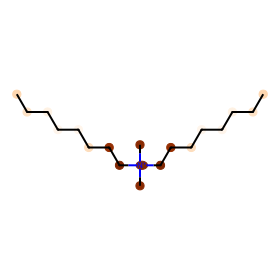

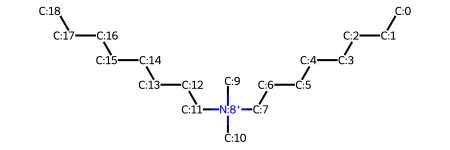

CAS: 18
prediction_Anti_value: 0.9998939
SMILES: CCCCCCCCCC[N+](C)(C)CCCCCCCC


[18:08:21] The new font size 1 is below the current minimum (6).


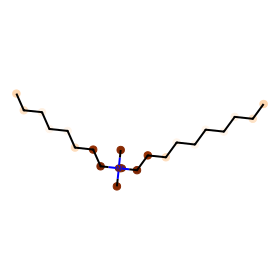

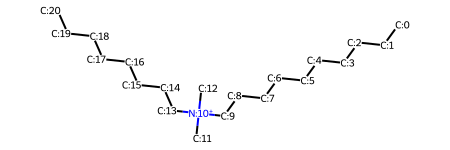

[18:08:21] The new font size 1 is below the current minimum (6).


CAS: 19
prediction_Anti_value: 0.99990237
SMILES: CCCCCCCCCC[N+](C)(C)CCCCCCCCCC


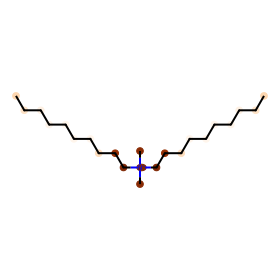

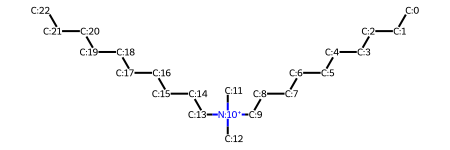

CAS: 20
prediction_Anti_value: 0.9998659
SMILES: CCCCCCCCCCCC[N+](C)(C)CCCCCCCCCC


[18:08:21] The new font size 1 is below the current minimum (6).


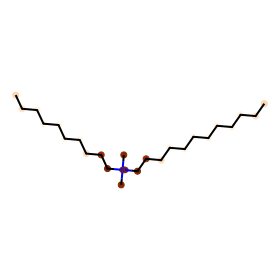

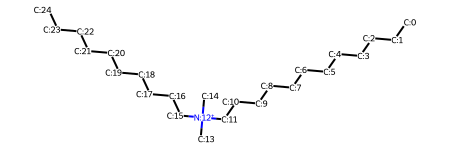

CAS: 21
prediction_Anti_value: 0.99972326
SMILES: CCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC


[18:08:21] The new font size 1 is below the current minimum (6).


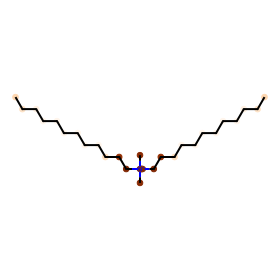

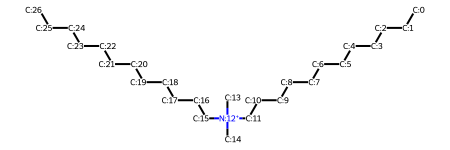

CAS: 22
prediction_Anti_value: 0.9991535
SMILES: CCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC


[18:08:21] The new font size 1 is below the current minimum (6).


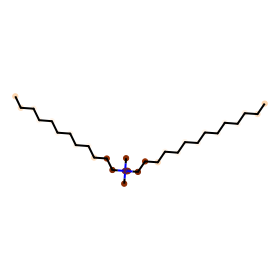

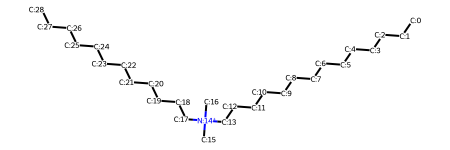

CAS: 23
prediction_Anti_value: 0.9991535
SMILES: CCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCC


[18:08:21] The new font size 1 is below the current minimum (6).


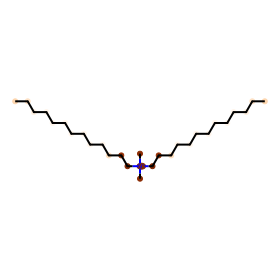

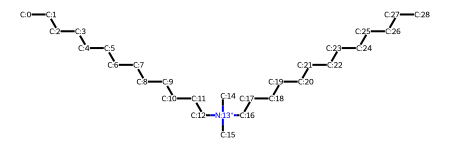

CAS: 24
prediction_Anti_value: 0.9983058
SMILES: CCCCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCC


[18:08:21] The new font size 1 is below the current minimum (6).


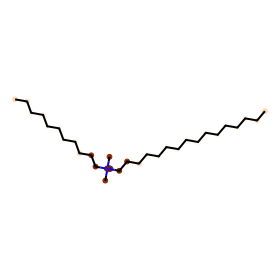

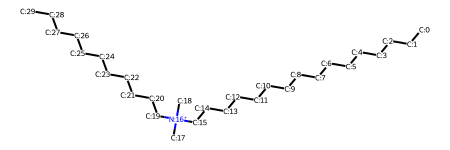

CAS: 25
prediction_Anti_value: 0.9983058
SMILES: CCCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCC


[18:08:21] The new font size 1 is below the current minimum (6).


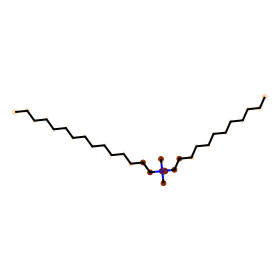

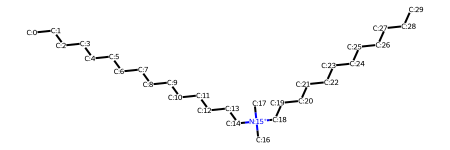

CAS: 26
prediction_Anti_value: 0.9983058
SMILES: CCCCCCCCCCCCCC[N+](C)(C)CCCCCCCCCCCCC


[18:08:21] The new font size 1 is below the current minimum (6).


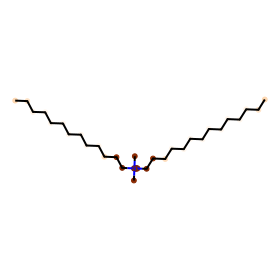

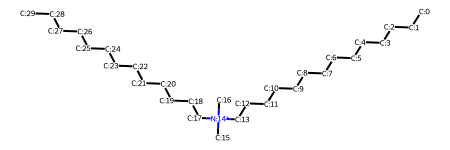

CAS: 27
prediction_Anti_value: 0.9995765
SMILES: CCCCCCCCCCCC[N+](C)(C)CC


[18:08:21] The new font size 1 is below the current minimum (6).


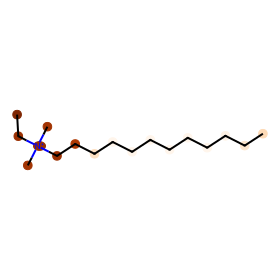

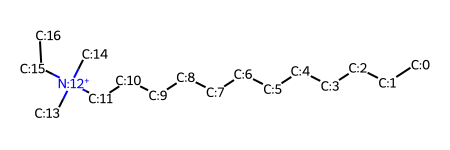

CAS: 28
prediction_Anti_value: 0.9998349
SMILES: CCCCCCCCCCCCCC[N+](C)(C)CC


[18:08:21] The new font size 1 is below the current minimum (6).


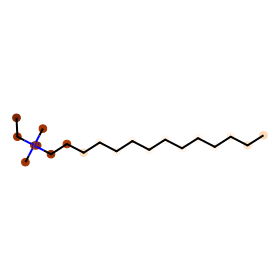

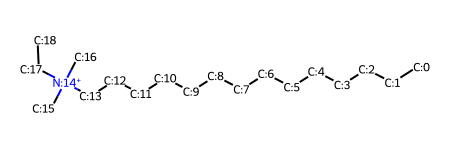

CAS: 29
prediction_Anti_value: 0.99990034
SMILES: CCCCCCCCCCCCCCCC[N+](C)(C)CC


[18:08:21] The new font size 1 is below the current minimum (6).


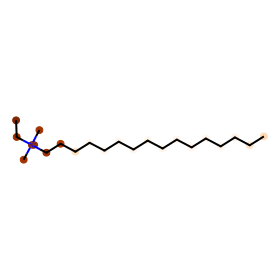

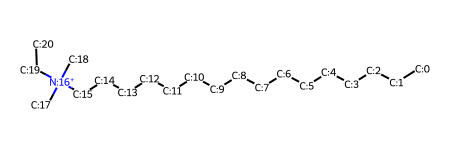

CAS: 30
prediction_Anti_value: 0.9999131
SMILES: CCCCCCCCCCCCCCCCCC[N+](C)(C)CC


[18:08:21] The new font size 1 is below the current minimum (6).


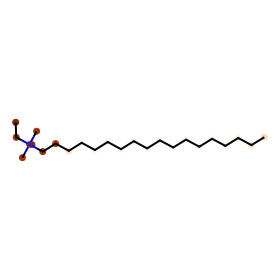

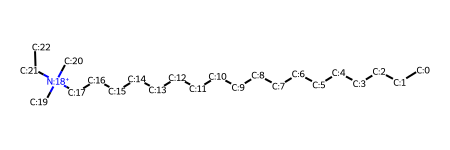

CAS: 31
prediction_Anti_value: 0.9998067
SMILES: CCCCCCCCCCCC[N+](C)(C)Cc1ccc(CC)cc1


[18:08:21] The new font size 1 is below the current minimum (6).


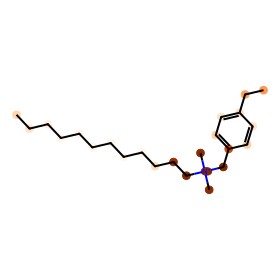

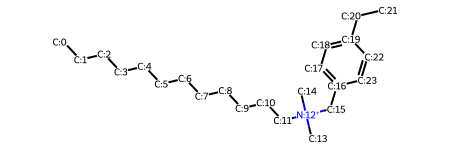

CAS: 32
prediction_Anti_value: 0.9997669
SMILES: CCCCCCCCCCCCCC[N+](C)(C)Cc1ccc(CC)cc1


[18:08:21] The new font size 1 is below the current minimum (6).


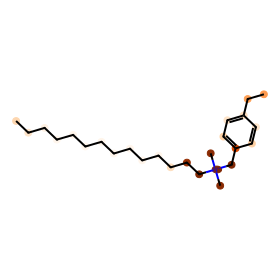

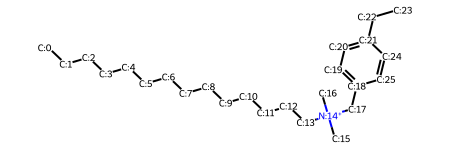

CAS: 33
prediction_Anti_value: 0.9999076
SMILES: CCCCCCCC[N+](C)(CCCCCCCC)CCCCCCCC


[18:08:21] The new font size 1 is below the current minimum (6).


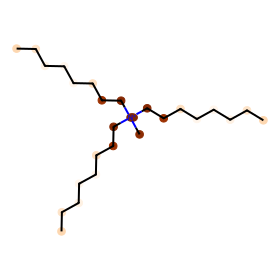

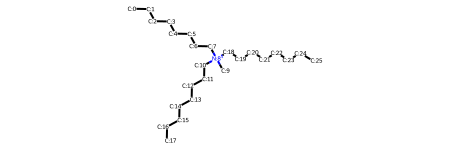

CAS: 34
prediction_Anti_value: 0.99971765
SMILES: CCCCCCCCCCCC[N+](C)(C)CCO


[18:08:21] The new font size 1 is below the current minimum (6).


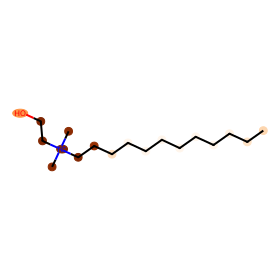

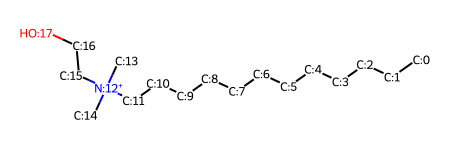

CAS: 35
prediction_Anti_value: 0.9998616
SMILES: CCCCCCCCCCCCCC[N+](C)(C)CCO


[18:08:21] The new font size 1 is below the current minimum (6).


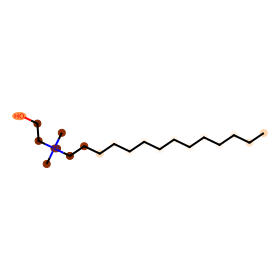

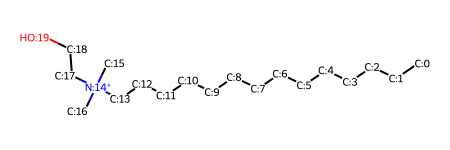

CAS: 36
prediction_Anti_value: 0.999899
SMILES: CCCCCCCCCCCCCCCC[N+](C)(C)CCO


[18:08:21] The new font size 1 is below the current minimum (6).


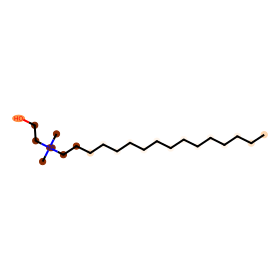

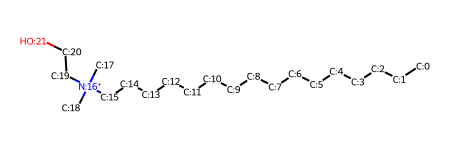

CAS: 37
prediction_Anti_value: 0.9998915
SMILES: CCCCCCCCCCCCCCCCCC[N+](C)(C)CCO


[18:08:21] The new font size 1 is below the current minimum (6).


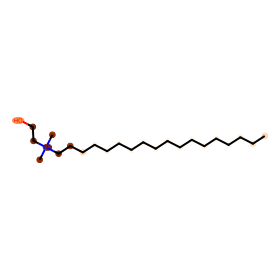

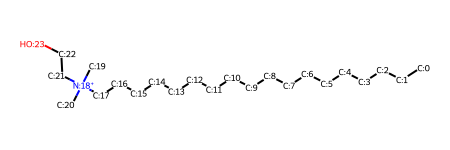

CAS: 38
prediction_Anti_value: 0.9998374
SMILES: CCCCCCCCCCCC[N+](C)(CCO)CCO


[18:08:21] The new font size 1 is below the current minimum (6).


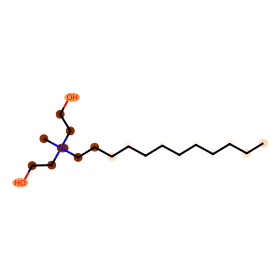

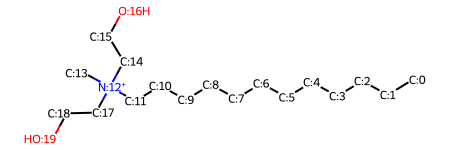

CAS: 39
prediction_Anti_value: 0.99990785
SMILES: CCCCCCCCCCCCCC[N+](C)(CCO)CCO


[18:08:21] The new font size 1 is below the current minimum (6).


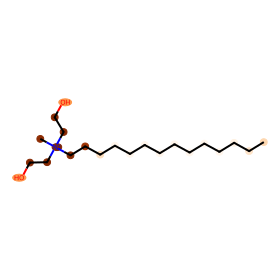

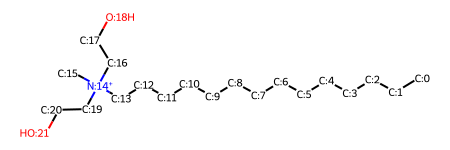

CAS: 40
prediction_Anti_value: 0.99982435
SMILES: CCCCCCCCCCCCCCCC(=O)OCC[N+](C)(C)CCO


[18:08:21] The new font size 1 is below the current minimum (6).


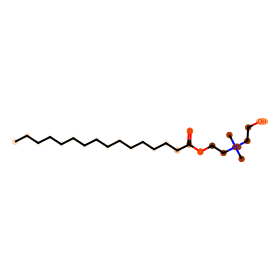

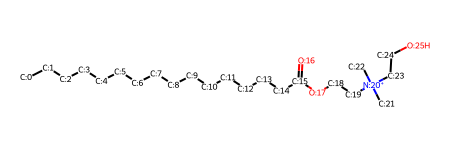

CAS: 41
prediction_Anti_value: 0.9997652
SMILES: CCCCCCCCCCCCCCCCCC(=O)OCC[N+](C)(C)CCO


[18:08:21] The new font size 1 is below the current minimum (6).


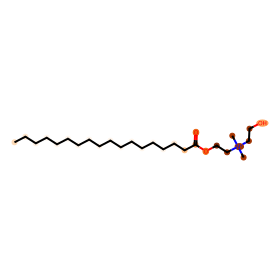

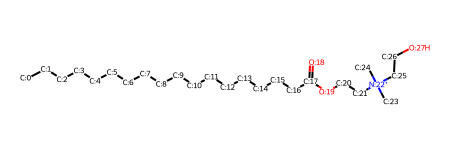

CAS: 42
prediction_Anti_value: 0.9998628
SMILES: CCCCCCCCCCCCCCCC(=O)OCC[N+](C)(CCO)CCO


[18:08:21] The new font size 1 is below the current minimum (6).


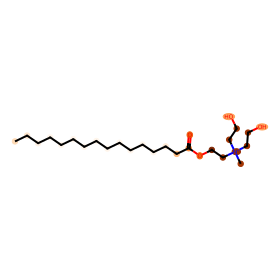

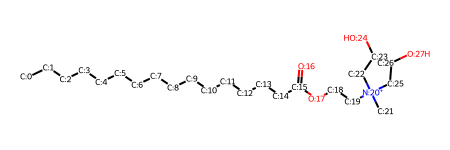

CAS: 43
prediction_Anti_value: 0.99979717
SMILES: CCCCCCCCCCCCCCCCCC(=O)OCC[N+](C)(CCO)CCO


[18:08:21] The new font size 1 is below the current minimum (6).


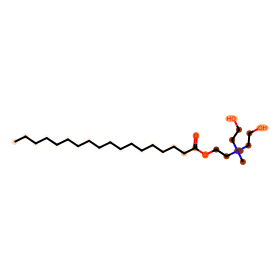

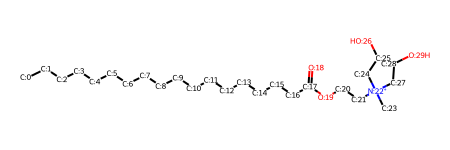

CAS: 44
prediction_Anti_value: 0.99854505
SMILES: CCCCCCCCCCCC(=O)NCCC[N+](C)(C)CC(=O)O


[18:08:21] The new font size 1 is below the current minimum (6).


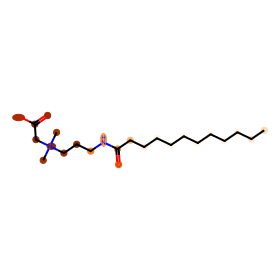

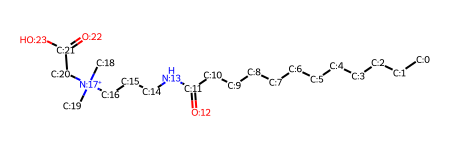

CAS: 45
prediction_Anti_value: 0.9993394
SMILES: CCCCCCCCCCCCCC(=O)NCCC[N+](C)(C)CC(=O)O


[18:08:22] The new font size 1 is below the current minimum (6).


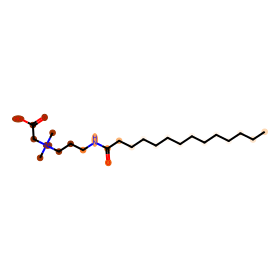

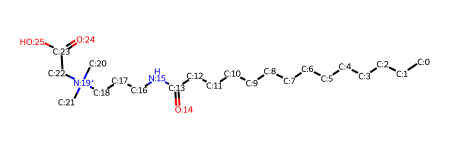

CAS: 46
prediction_Anti_value: 0.99949265
SMILES: CCCCCCCCCCCCCCCC(=O)NCCC[N+](C)(C)CC(=O)O


[18:08:22] The new font size 1 is below the current minimum (6).


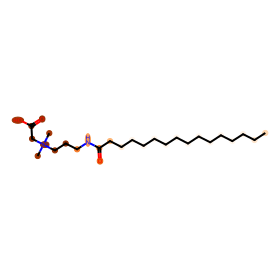

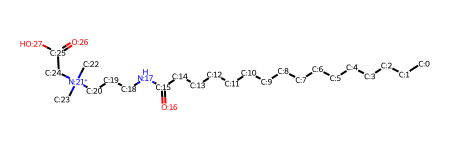

CAS: 47
prediction_Anti_value: 0.99925953
SMILES: CC(C)(C)CC(C)(C)c1ccc(OCCOCC[N+](C)(C)Cc2ccccc2)cc1


[18:08:22] The new font size 1 is below the current minimum (6).


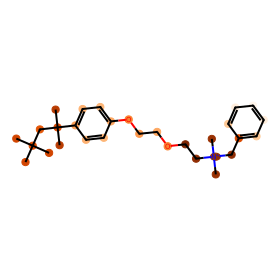

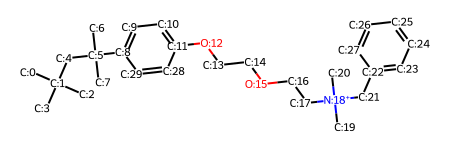

CAS: 48
prediction_Anti_value: 0.9998442
SMILES: CCCCCCCCCCCC[N+](C)(C)CCOc1ccccc1


[18:08:22] The new font size 1 is below the current minimum (6).


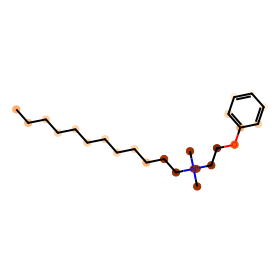

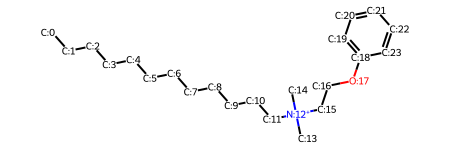

CAS: 49
prediction_Anti_value: 0.99967194
SMILES: CCCCCCCCCCCC[n+]1ccccc1


[18:08:22] The new font size 1 is below the current minimum (6).


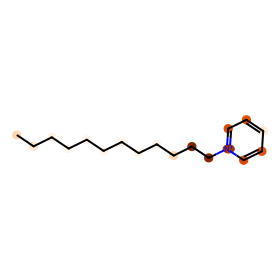

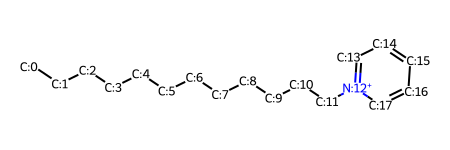

CAS: 50
prediction_Anti_value: 0.99978405
SMILES: CCCCCCCCCCCCCCCC[n+]1ccccc1


[18:08:22] The new font size 1 is below the current minimum (6).


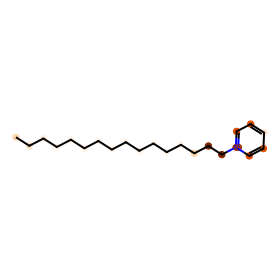

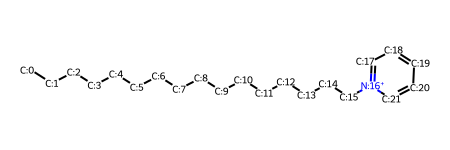

In [22]:
model_for_viz.eval()
test_MAE_list = []
test_MSE_list = []

out_feature_sorted = []
out_weight_sorted = []
mol_feature_sorted = []


dataset = remained_df
test_MAE_list = []
test_MSE_list = []
valList = np.arange(0,dataset.shape[0])
batch_list = []
a={}

def save_svg_as_file(svg, filename):
    with open(filename, 'w') as f:
        f.write(svg)

for i in range(0, dataset.shape[0], batch_size):
    batch = valList[i:i+batch_size]
    batch_list.append(batch)
for counter, test_batch in enumerate(batch_list):
    batch_df = dataset.loc[test_batch,:]
    smiles_list = batch_df.cano_smiles.values
    #y_val = batch_df[tasks[0]].values

    x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
    atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, \
    mol_attention_weight_viz, mol_prediction = model_for_viz(
        torch.Tensor(x_atom), torch.Tensor(x_bonds),
        torch.cuda.LongTensor(x_atom_index),
        torch.cuda.LongTensor(x_bond_index),
        torch.Tensor(x_mask))


    #mol_pred = np.array(mol_prediction.data.squeeze().cpu().numpy())
    y_pred = F.softmax(mol_prediction,dim=-1).data.cpu().numpy()[:,1]
    atom_feature = np.stack([atom_feature_viz[L].cpu().detach().numpy() for L in range(radius+1)])
    atom_weight = np.stack([mol_attention_weight_viz[t].cpu().detach().numpy() for t in range(T)])
    mol_feature = np.stack([mol_feature_viz[t].cpu().detach().numpy() for t in range(T)])

    mol_feature_sorted.extend([mol_feature[:,i,:] for i in range(mol_feature.shape[1])])
    for i, smiles in enumerate(smiles_list):
        atom_num = i
        ind_mask = x_mask[i]
        ind_atom = smiles_to_rdkit_list[smiles]
        ind_feature = atom_feature[:, i]
        ind_weight = atom_weight[:, i]
        out_feature = []
        out_weight = []
        for j, one_or_zero in enumerate(list(ind_mask)):
            if one_or_zero == 1.0:
                out_feature.append(ind_feature[:,j])
                out_weight.append(ind_weight[:,j])
#         out_feature_sorted.extend([out_feature[m] for m in np.argsort(ind_atom)])
#         out_weight_sorted.extend([out_weight[m] for m in np.argsort(ind_atom)])

        mol = Chem.MolFromSmiles(smiles)
        index = dataset[dataset.cano_smiles == smiles].index.tolist()[0]
        CAS_num = dataset.loc[index,'cas']
        label = dataset.loc[index,'Anti']
        print('CAS: '+ str(CAS_num))
        print('prediction_Anti_value: '+str(y_pred[atom_num]))
        #print('Label: '+str(label))
        print('SMILES: '+smiles)
        a[smiles]=[]
        a[smiles].append(str(y_pred[atom_num]))
        a[smiles].append(str(CAS_num))
        #a[smiles].append(str(label))
        ## a[smiles]={str(y_pred[atom_num])}

        weight_norm = min_max_norm([out_weight[m][0] for m in np.argsort(ind_atom)])
        norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
        import matplotlib.cm as cm
        cmap = cm.get_cmap('Oranges')
        plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
        atom_colors = {}
        weight_norm = np.array(weight_norm).flatten()
        threshold = weight_norm[np.argsort(weight_norm)[0]]
        weight_norm = np.where(weight_norm < threshold, 0, weight_norm)

        #print('Weight_Norm:',weight_norm)
        for i in range(len(ind_atom)):
            atom_colors[i] = plt_colors.to_rgba(float(weight_norm[i]))
        rdDepictor.Compute2DCoords(mol)

        drawer = rdMolDraw2D.MolDraw2DSVG(280,280)
        drawer.SetFontSize(1)
        op = drawer.drawOptions()

        mol = rdMolDraw2D.PrepareMolForDrawing(mol)
        drawer.DrawMolecule(mol,highlightAtoms=range(0,len(ind_atom)),highlightBonds=[],
            highlightAtomColors=atom_colors)
        drawer.FinishDrawing()
        svg = drawer.GetDrawingText()
        svg2 = svg.replace('svg:','')
        svg3 = SVG(svg2)
        display(svg3)


        filename = str(CAS_num) + '.svg'
        save_svg_as_file(svg, filename)

        display(mol_with_atom_index(mol))

In [ ]:
import os
import matplotlib.pyplot as plt
import cairosvg
from IPython.display import SVG


def save_svg_as_file(svg, filename):
    with open(filename, 'w') as f:
        f.write(svg)

# Generate a colorbar
scatter = plt.scatter([], [], c=[], cmap='Oranges', norm=norm)
plt.colorbar(scatter)

# Save the colorbar as an SVG format
colorbar_filename = 'colorbar.svg'
plt.savefig(colorbar_filename, format='svg')
plt.close()


In [ ]:
!apt-get update
!apt-get install -y inkscape

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,359 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease [24.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,282 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packag

In [ ]:
import os

# Loop through SVG files in a directory and convert them to TIFF format
input_folder = './svg'
output_folder = './tiff'
# Ensure the output folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate over all files in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith('.svg'):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, os.path.splitext(filename)[0] + '.tiff')

        # Use Inkscape to convert SVG to TIFF, specifying a resolution of 300dpi
        os.system(f'inkscape -z -f {input_path} -e {output_path} -d 300')

        print(f'Converted {input_path} to {output_path}')


Converted ./svg/2802.svg to ./tiff/2802.tiff
Converted ./svg/2801.svg to ./tiff/2801.tiff
Converted ./svg/2800.svg to ./tiff/2800.tiff
Converted ./svg/2799.svg to ./tiff/2799.tiff
Converted ./svg/2798.svg to ./tiff/2798.tiff
Converted ./svg/2797.svg to ./tiff/2797.tiff
Converted ./svg/2796.svg to ./tiff/2796.tiff
Converted ./svg/2795.svg to ./tiff/2795.tiff
Converted ./svg/2794.svg to ./tiff/2794.tiff
Converted ./svg/2793.svg to ./tiff/2793.tiff
Converted ./svg/2792.svg to ./tiff/2792.tiff
Converted ./svg/2867.svg to ./tiff/2867.tiff
Converted ./svg/2860.svg to ./tiff/2860.tiff
Converted ./svg/2864.svg to ./tiff/2864.tiff
Converted ./svg/2861.svg to ./tiff/2861.tiff
Converted ./svg/2791.svg to ./tiff/2791.tiff
Converted ./svg/2790.svg to ./tiff/2790.tiff
Converted ./svg/2789.svg to ./tiff/2789.tiff
Converted ./svg/2863.svg to ./tiff/2863.tiff
Converted ./svg/2868.svg to ./tiff/2868.tiff
Converted ./svg/2862.svg to ./tiff/2862.tiff
Converted ./svg/2865.svg to ./tiff/2865.tiff
Converted 